# Overview

1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
2. [Baseline Model](#Baseline-Model)
3. [Preprocessing](#Preprocessing)
4. [Feature Selection](#Feature-Selection)
5. [Model Selection](#Model-Selection)

---
### Imports

In [4]:
import os
import pandas as pd
import numpy as np
import functools
import itertools
import math
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, RocCurveDisplay
from sklearn.linear_model import SGDClassifier

---
### Load Data

In [5]:
# create dictionary with filename:data as key:value pairs
data = {dataset_name.replace('.xlsx', ''): pd.read_excel(f'Data/{dataset_name}') for dataset_name in os.listdir('Data') if 'xlsx' in dataset_name}

# merge train datasets on PatientID
data_frames = [data['train_demo'], data['train_habits'], data['train_health']]
df = functools.reduce(lambda  left,right: pd.merge(left,right,on=['PatientID'], how='outer'), data_frames).set_index('PatientID')

# merge test datasets on PatientID
data_frames = [data['test_demo'], data['test_habits'], data['test_health']]
df_test = functools.reduce(lambda  left,right: pd.merge(left,right,on=['PatientID'], how='outer'), data_frames).set_index('PatientID')

---
### Exploratory Data Analysis

In [6]:
# first look on the data
df.sample(5)

,Name,Birth_Year,Region,Education,Disease,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
PatientID,,,,,,,,,,,,,,,,,,
1056,Mr. Ron Grossman,1966,Yorkshire and the Humber,Elementary School (1st to 9th grade),1,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,167,68,197,120,20,9,Not sure,"I don't have diabetes, but I have direct famil..."
1548,Mrs. Lora Romanelli,1971,East Midlands,High School Incomplete (10th to 11th grade),1,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,Between one liter and two liters,151,59,299,120,19,2,More than 3 years,I have/had pregnancy diabetes or borderline di...
1982,Mrs. Jenna Rondeau,1955,West Midlands,High School Graduate,1,No,I usually consume alcohol every day,No,3 to 4 pieces of fruit in average,More than half a liter but less than one liter,158,71,227,106,16,1,More than 3 years,Neither I nor my immediate family have diabetes.
1344,Mr. Daniel Terry,1981,North East,University Complete (3 or more years),1,No,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,Less than half a liter,173,79,161,120,25,0,More than 3 years,I do have diabetes
1779,Mrs. Patricia President,1988,East Midlands,University Complete (3 or more years),1,No,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,157,65,214,118,27,3,More than 3 years,I do have diabetes


In [24]:
pd.DataFrame(df.groupby(["Region", "Disease"]).size()).to_csv("Test.csv")

In [4]:
# list datatypes
df.dtypes

Name                object
Birth_Year           int64
Region              object
Education           object
Disease              int64
Smoking_Habit       object
Drinking_Habit      object
Exercise            object
Fruit_Habit         object
Water_Habit         object
Height               int64
Weight               int64
High_Cholesterol     int64
Blood_Pressure       int64
Mental_Health        int64
Physical_Health      int64
Checkup             object
Diabetes            object
dtype: object

In [5]:
# check for missing values and empty strings
pd.concat([df.isnull().sum(),df.eq('').sum()],keys=['Nulls','Empty Strings'],axis=1)

,Nulls,Empty Strings
Name,0,0
Birth_Year,0,0
Region,0,0
Education,13,0
Disease,0,0
Smoking_Habit,0,0
Drinking_Habit,0,0
Exercise,0,0
Fruit_Habit,0,0
Water_Habit,0,0


In [6]:
# check for duplicated rows
df.duplicated().sum()

0

In [7]:
# descriptive statistics
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,800,799,Mr. Gary Miller,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Birth_Year,800.0,NaN,NaN,NaN,1966.04375,15.421872,1855.0,1961.0,1966.0,1974.0,1993.0
Region,800,10,East Midlands,154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,787,6,University Complete (3 or more years),239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disease,800.0,NaN,NaN,NaN,0.51375,0.500124,0.0,0.0,1.0,1.0,1.0
Smoking_Habit,800,2,No,673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drinking_Habit,800,3,I usually consume alcohol every day,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise,800,2,No,536,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fruit_Habit,800,5,Less than 1. I do not consume fruits every day.,452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Water_Habit,800,3,Between one liter and two liters,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN


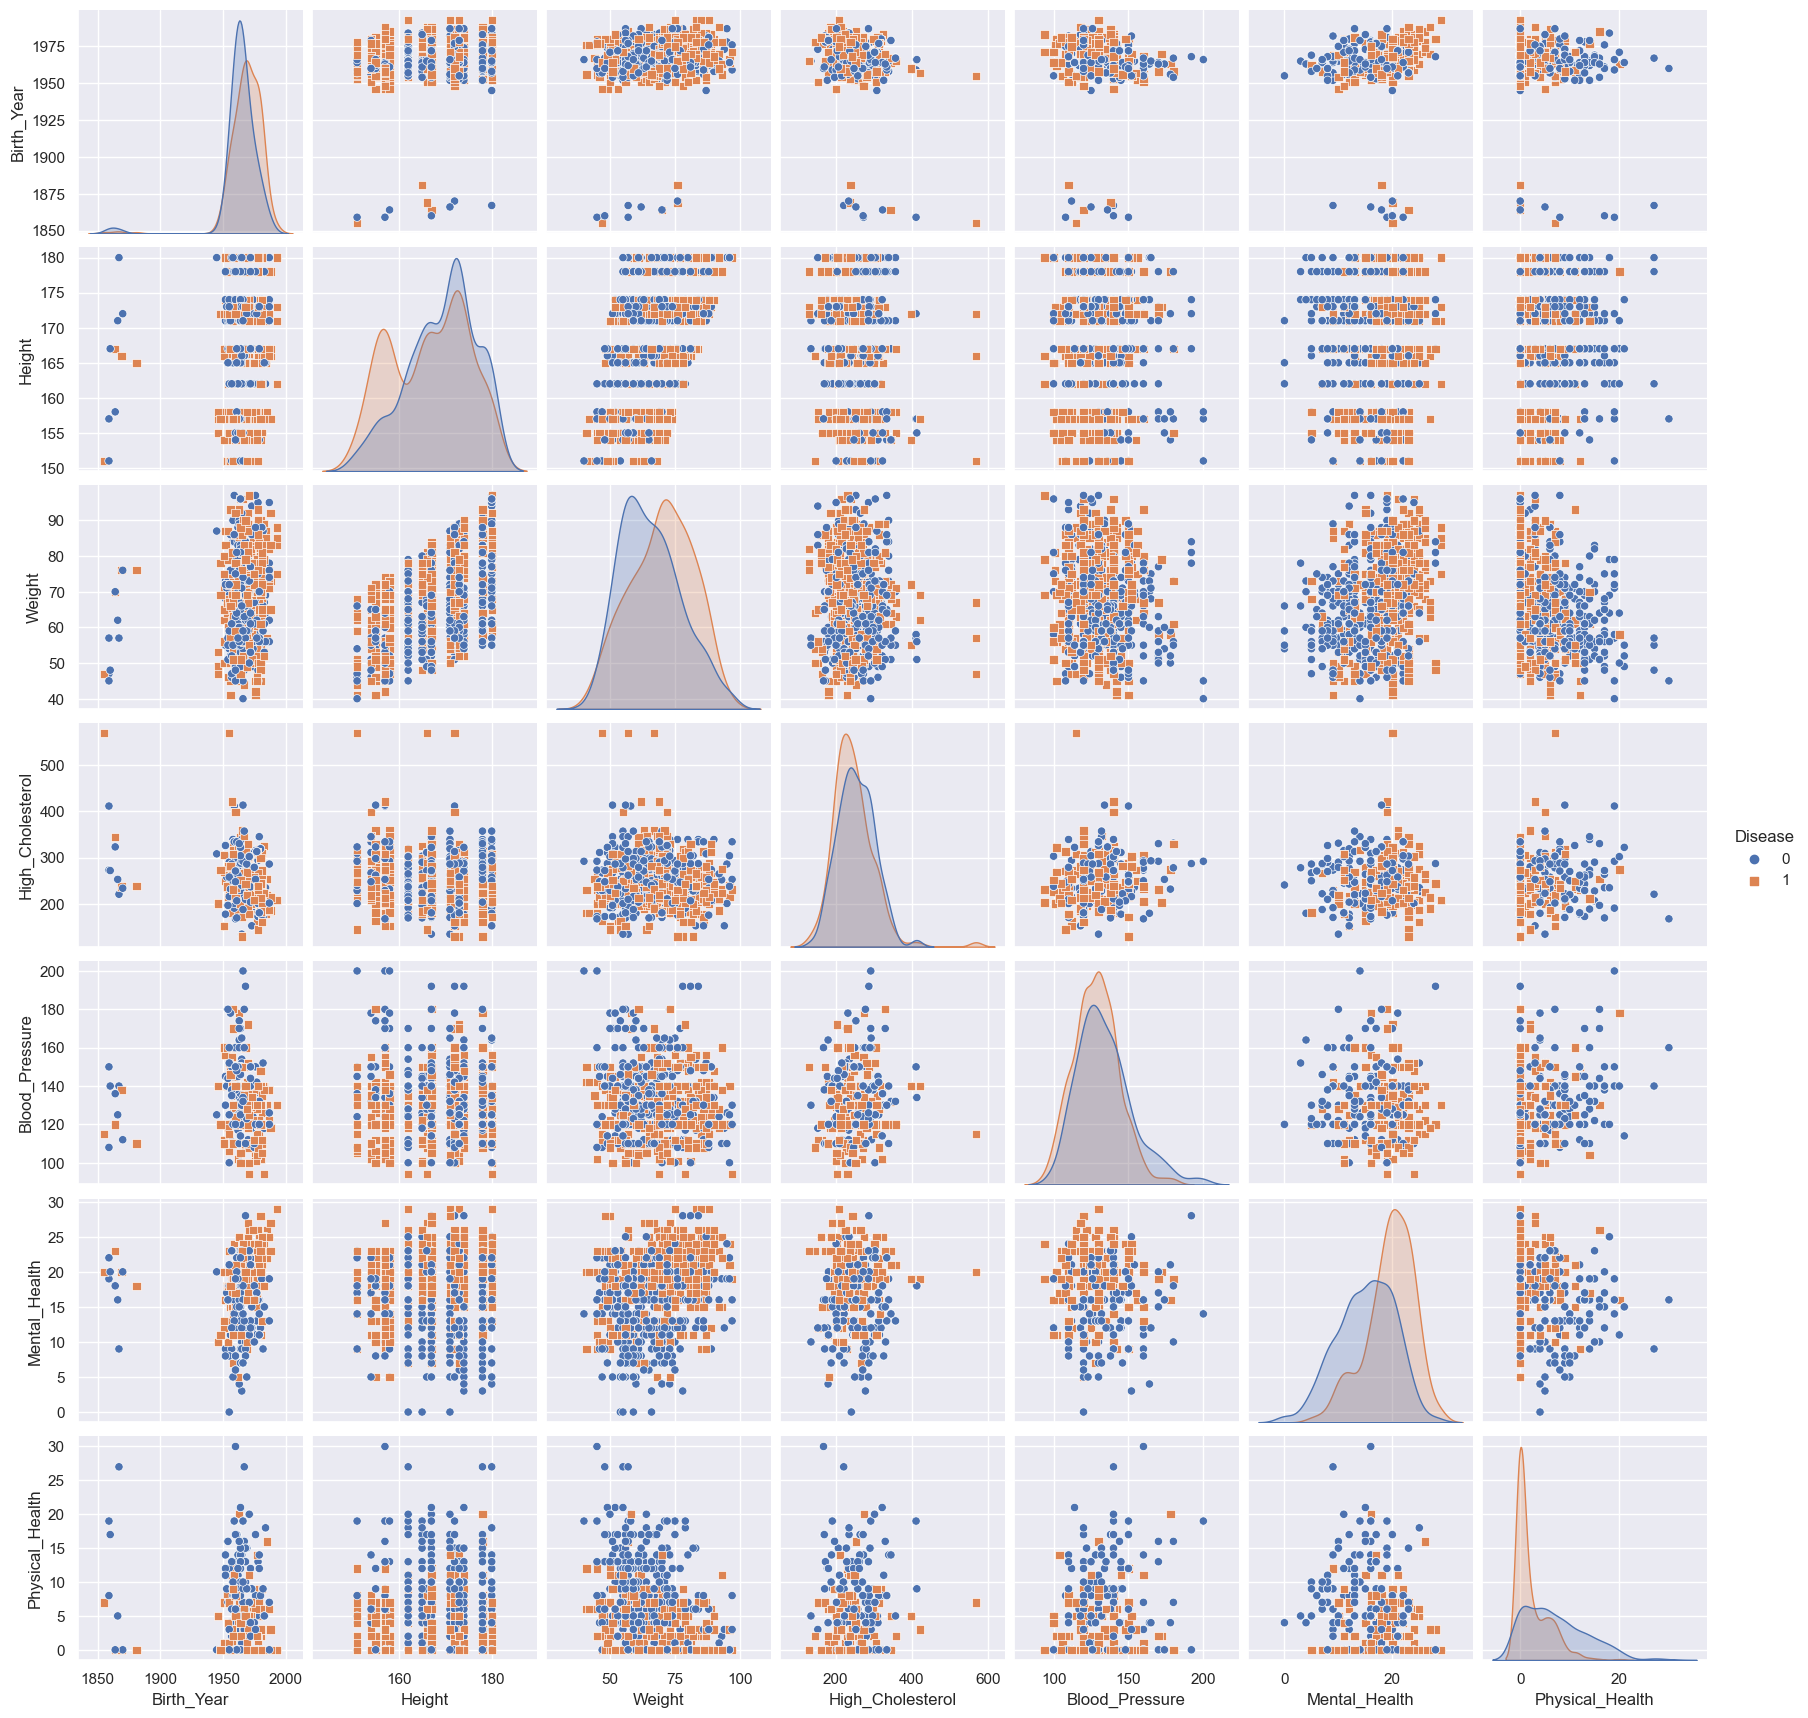

In [8]:
sns.set()

# plot pairwise relationships and densities
sns.pairplot(df, hue = 'Disease', markers = ['o', 's'])
plt.show()

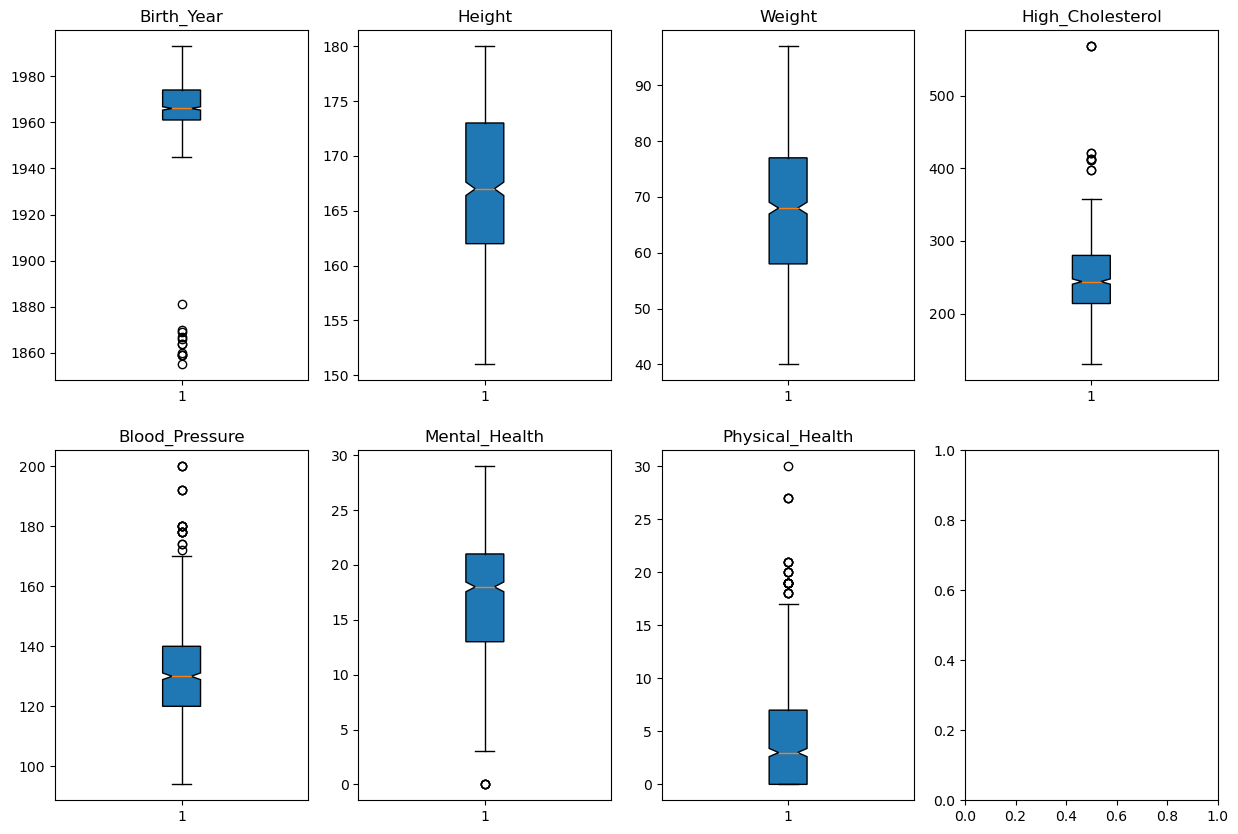

In [5]:
# select numeric features (exclude target array)
df_numeric_features = list(df.select_dtypes(include = np.number).columns)
df_numeric_features.remove('Disease')

# boxplot of numeric features
fig, ax = plt.subplots(math.ceil(len(df_numeric_features)/4),4, figsize = (15,10))
for ax, feat in zip(ax.flatten(), df_numeric_features):
    ax.boxplot(df[feat], notch = True, patch_artist = True)
    ax.set_title(feat)

plt.show()

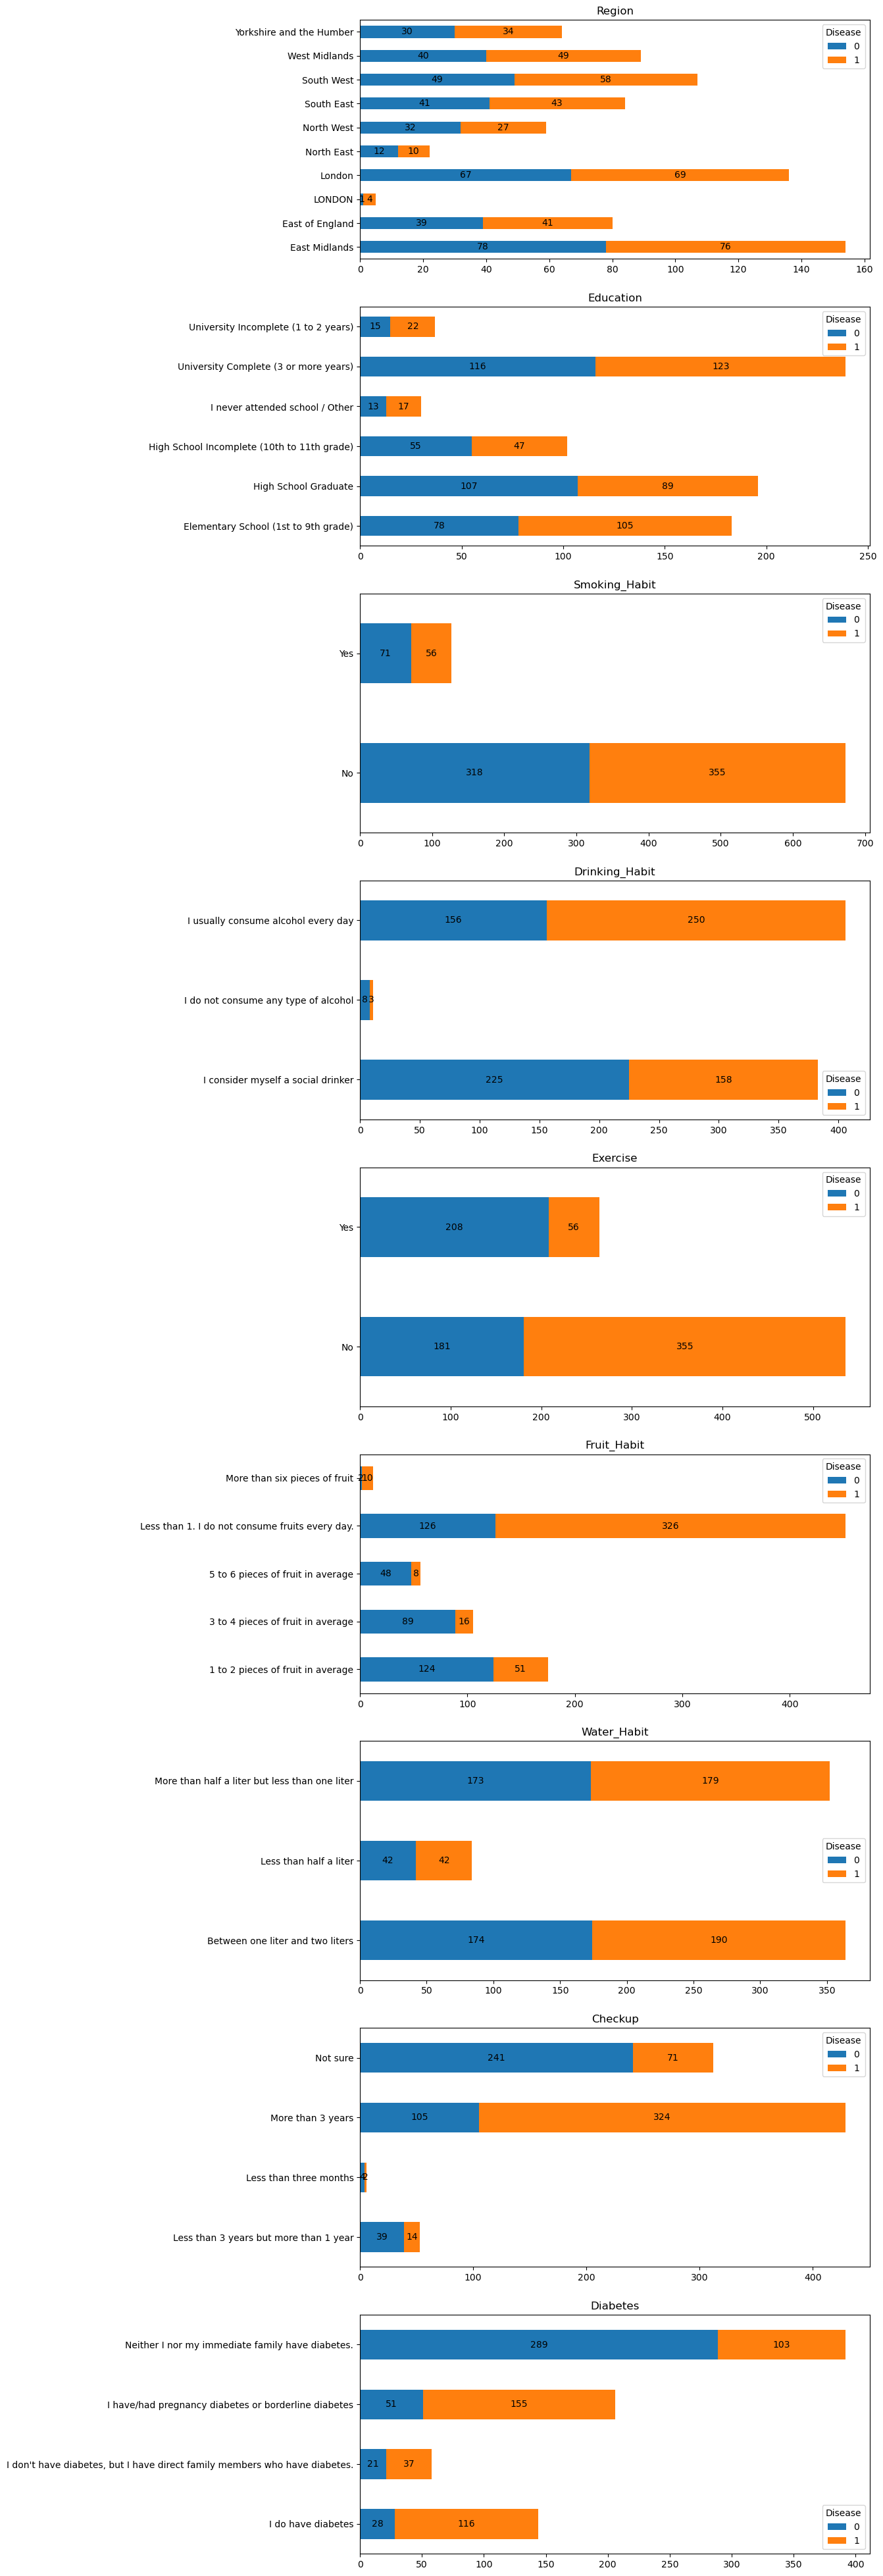

In [6]:
# select categorical features (exclude name column)
df_categorical_features = list(df.select_dtypes(exclude = np.number).columns)
df_categorical_features.remove('Name')

# stacked barplot of categorical features (with regard to target value)
fig, ax = plt.subplots(len(df_categorical_features), figsize = (10,50))
for ax, feat in zip(ax.flatten(), df_categorical_features):
    pivot_tbl = df[[feat, 'Disease']].pivot_table(index = feat, columns = ['Disease'],  aggfunc=len)
    graph = pivot_tbl.plot(kind='barh', stacked=True, title=feat, ax=ax)
    ax.set_ylabel('')
    for c in ax.containers:
        ax.bar_label(c, label_type='center')

plt.show()

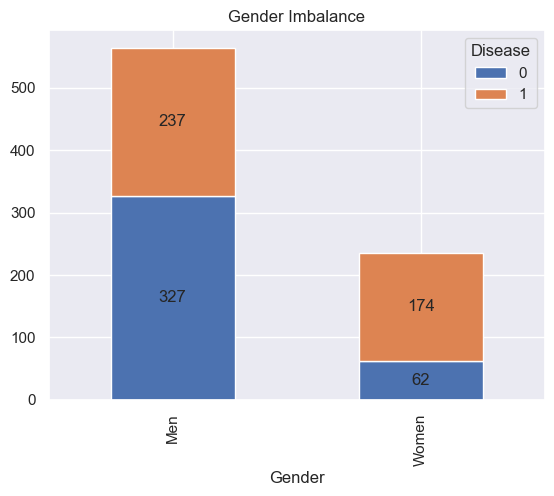

In [11]:
gender_imbalance = df.copy()
gender_imbalance['Gender'] = ['Men' if i.split(' ')[0] == 'Mr.' else 'Women' for i in gender_imbalance.Name]
pivot_tbl = gender_imbalance[['Gender', 'Disease']].pivot_table(index = 'Gender', columns = ['Disease'],  aggfunc=len)

ax = pivot_tbl.plot(kind='bar', stacked=True, title='Gender Imbalance')

for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.show()

---
### Baseline Model

- LogisticRegression with only numeric values

In [7]:
# split to data:target
x, y = df.drop(columns = ['Disease']), df['Disease']

In [8]:
# select numeric features
initial_xnumeric = x.select_dtypes(include = np.number)
initial_xnumeric_cols = initial_xnumeric.columns

# stratified train-test split
xtrain, xval, ytrain, yval = train_test_split(initial_xnumeric, y, random_state = 0 ,test_size = 0.2, shuffle = True , stratify = y)

# save train split indices to track performance on the same validation set during the project
train_indices = xtrain.index #####random state

In [9]:
model = LogisticRegression(max_iter = 500, random_state = 1)
model.fit(xtrain,ytrain)

ypred = model.predict(xval)

baseline_f1 = f1_score(yval, ypred)

print(f'F1 score: {baseline_f1}')

F1 score: 0.7790697674418605


---
### Preprocessing

In [10]:
def preprocessing(dataframe):

    # fix Birth_Year errors. here we assume that the outliers are typos
    # the numbers 8 & 9 are pretty close to each other on a keyboard. therefore we add 100 to every year that's smaller than 1900
    # (e.g. 1869 --> 1969)
    dataframe['Birth_Year'] = [i + 100 if i < 1900 else i for i in dataframe['Birth_Year']]

    # add Age column
    dataframe['Age'] = [2022 - i for i in dataframe['Birth_Year']]

    # add Gender column (1: Male, 0: Female)
    # afterwards drop column Name
    dataframe['Gender']  = [1 if i.split(' ')[0] == 'Mr.' else 0 for i in dataframe['Name']]
    dataframe.drop(columns = ['Name'], inplace = True)

    # add BMI columns
    dataframe['BMI'] = [i/(j/100)**2 for i, j in zip(dataframe['Weight'], dataframe['Height'])]
    dataframe['BMI_Cateogry'] = [0 if i < 18.5 else 1 if i < 25 else 2 if i < 30 else 3 if i < 35 else 4 for i in dataframe['BMI']]

    # set all region values to lowercase
    dataframe['Region'] = [i.lower() for i in dataframe['Region']]

    # handle High_Cholesterol, Blood_Pressure, Physical_Health
    # flooring and capping outliers
    for col in ['High_Cholesterol', 'Blood_Pressure', 'Physical_Health']:
        q25, q75, iqr = dataframe[col].quantile(.25), dataframe[col].quantile(.75), dataframe[col].quantile(.75) - dataframe[col].quantile(.25)
        upper_lim = q75 + 1.5 * iqr
        lower_lim = q25 - 1.5 * iqr
        dataframe[col] = [upper_lim if i > upper_lim else lower_lim if i < lower_lim else i for i in dataframe[col]]

    # encode Smoking_Habit & Exercise to binary (1: Yes, 0: No)
    dataframe['Smoking_Habit'] = [1 if i == 'Yes' else 0 for i in dataframe['Smoking_Habit']]
    dataframe['Exercise'] = [1 if i == 'Yes' else 0 for i in dataframe['Exercise']]    
    
    # manual encoding of specific feature to don't mess up the ranking
    # all of these features have a specific ranking structure
    # another advantage is the avoidance of dimensionality increase through One-hot-encoding all categorical features

    # impute missing values in column "Education" with mode
    # encode Education
    dataframe['Education'].fillna(dataframe['Education'].mode()[0], inplace=True)
    edu_map = {
            'I never attended school / Other'               : 0,
            'Elementary School (1st to 9th grade)'          : 1,
            'High School Incomplete (10th to 11th grade)'   : 2,
            'High School Graduate'                          : 3,
            'University Incomplete (1 to 2 years)'          : 4,
            'University Complete (3 or more years)'         : 5
            }
    dataframe['Education'] = [edu_map[i] if i in edu_map.keys() else np.nan for i in dataframe['Education']]

    drink_map = {
            'I do not consume any type of alcohol'          : 0,
            'I consider myself a social drinker'            : 1,
            'I usually consume alcohol every day'           : 2
            }
    dataframe['Drinking_Habit'] = [drink_map[i] if i in drink_map.keys() else np.nan for i in dataframe['Drinking_Habit']]

    fruit_map = {
            'Less than 1. I do not consume fruits every day.'   : 0,
            '1 to 2 pieces of fruit in average'                 : 1,
            '3 to 4 pieces of fruit in average'                 : 2,
            '5 to 6 pieces of fruit in average'                 : 3,
            'More than six pieces of fruit'                     : 4
            }
    dataframe['Fruit_Habit'] = [fruit_map[i] if i in fruit_map.keys() else np.nan for i in dataframe['Fruit_Habit']]

    water_map = {
            'Less than half a liter'                            : 0,
            'More than half a liter but less than one liter'    : 1,
            'Between one liter and two liters'                  : 2
            }
    dataframe['Water_Habit'] = [water_map[i] if i in water_map.keys() else np.nan for i in dataframe['Water_Habit']]

    checkup_map = {
            'Not sure'                                          : 0,
            'More than 3 years'                                 : 1,
            'Less than 3 years but more than 1 year'            : 2,
            'Less than three months'                            : 3
            }
    dataframe['Checkup'] = [checkup_map[i] if i in checkup_map.keys() else np.nan for i in dataframe['Checkup']]

    diabetes_map = {
            'I do have diabetes'                                                            : 0,
            'I have/had pregnancy diabetes or borderline diabetes'                          : 1,
            "I don't have diabetes, but I have direct family members who have diabetes."    : 2,
            'Neither I nor my immediate family have diabetes.'                              : 3
            }
    dataframe['Diabetes'] = [diabetes_map[i] if i in diabetes_map.keys() else np.nan for i in dataframe['Diabetes']]

    return dataframe

In [11]:
x_preprocessed = preprocessing(x.copy())

---
### Check for scalers

In [12]:
scalers = [StandardScaler(), MinMaxScaler(), MinMaxScaler(feature_range = (-1,1)), RobustScaler()]

In [13]:
def test_scaler_encoder(X,Y,scaler_options,classifier):

        ranking = {'scaler':[],'score':[]}

        for scl in scaler_options:

                # create K-fold crossvalidation
                skf = StratifiedKFold(shuffle=True, random_state = 0)

                # scores list for every k-fold f1-score

                scores = []
                # calculate f1-score for each train-test split with the given scaler:encoder combination
                for train_index, val_index in skf.split(X, Y):
                        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                        y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

                        numeric_features, categorical_features = X_train.select_dtypes(include = np.number).columns, X_train.select_dtypes(exclude = np.number).columns

                        numeric_transformer = Pipeline(steps=[
                                ('scaler', scl)
                                ])

                        categorical_transformer = Pipeline(steps=[
                                ('encoder', OneHotEncoder(handle_unknown='ignore'))
                                ])

                        preprocessor = ColumnTransformer(transformers=[
                                ('cat', categorical_transformer, categorical_features),
                                ('num', numeric_transformer, numeric_features)
                                ])

                        model = Pipeline(steps=[
                                ("preprocessor", preprocessor),
                                ("classifier", classifier)
                                ])
                        
                        model.fit(X_train, y_train)
                        scores.append(round(f1_score(y_val, model.predict(X_val)),4))

                ranking['scaler'].append(scl)
                ranking['score'].append(np.mean(scores))

        return pd.DataFrame(ranking).sort_values('score', ascending=False)

In [14]:
test_scaler_encoder(x_preprocessed, y, scalers, LogisticRegression(max_iter=500, random_state=1))

,scaler,score
3,RobustScaler(),0.83554
0,StandardScaler(),0.83254
2,"MinMaxScaler(feature_range=(-1, 1))",0.83138
1,MinMaxScaler(),0.82576


In [15]:
test_scaler_encoder(x_preprocessed, y, scalers, SVC(random_state=1))

,scaler,score
3,RobustScaler(),0.90464
0,StandardScaler(),0.88918
2,"MinMaxScaler(feature_range=(-1, 1))",0.85850
1,MinMaxScaler(),0.83916


In [21]:
#test_scaler_encoder(x_preprocessed, y, scalers, MLPClassifier(hidden_layer_sizes=(10,2), max_iter=1500, random_state=1))

In [16]:
test_scaler_encoder(x_preprocessed, y, scalers, DecisionTreeClassifier(random_state=1))

,scaler,score
0,StandardScaler(),0.94154
1,MinMaxScaler(),0.93890
2,"MinMaxScaler(feature_range=(-1, 1))",0.93890
3,RobustScaler(),0.93890


In [17]:
test_scaler_encoder(x_preprocessed, y, scalers, RandomForestClassifier(random_state=1))

,scaler,score
3,RobustScaler(),0.96328
0,StandardScaler(),0.96216
1,MinMaxScaler(),0.96082
2,"MinMaxScaler(feature_range=(-1, 1))",0.96082


---
### Train/Test Split

In [18]:
xtrain, xval = x_preprocessed.loc[train_indices], x_preprocessed.loc[~x_preprocessed.index.isin(train_indices)]
ytrain, yval = y.loc[train_indices], y.loc[~x_preprocessed.index.isin(train_indices)]

#Join the preprocessed dataset with the target variable for the correlation
preprocessed_complete = x_preprocessed.join(y)

---
### Prepare Train/Test Split (One-Hot-Encode, Scale) 

In [19]:
def encode_scale(dataframe, reset_fit=False):

    '''
    One-hot-encode and scales dataframe
    If reset_fit set to TRUE encoder & scaler get refitted
    '''

    # fit_transform if no scaler and one-hot-encoder is already fitted
    if not('ohe' in globals() and 'scl' in globals()) or reset_fit == True:
        xnumeric, xcategorical = dataframe.select_dtypes(include = np.number), dataframe.select_dtypes(exclude = np.number)
        # One-hot-encoding
        # set encoder to global variable to re-use it afterwards
        global ohe
        ohe = OneHotEncoder(handle_unknown='ignore')
        categorical_encoded = pd.DataFrame(ohe.fit_transform(xcategorical).toarray(), columns = ohe.get_feature_names_out(), index = xcategorical.index)
        dataframe_encoded = pd.concat([xnumeric, categorical_encoded], axis = 1)
        # Robust-scaling
        # set scaler to global variable to re-use it afterwards
        global scl
        scl = RobustScaler()
        dataframe_scaled = pd.DataFrame(scl.fit_transform(dataframe_encoded), columns = dataframe_encoded.columns, index = dataframe_encoded.index)
        print('fit & transform successful...')
        return dataframe_scaled

    # transform only if scaler and one-hot-encoder is already fitted
    else:
        xnumeric, xcategorical = dataframe.select_dtypes(include = np.number), dataframe.select_dtypes(exclude = np.number)
        # One-hot-encoding
        categorical_encoded = pd.DataFrame(ohe.transform(xcategorical).toarray(), columns = ohe.get_feature_names_out(), index = xcategorical.index)
        dataframe_encoded = pd.concat([xnumeric, categorical_encoded], axis = 1)
        #Robust-scaling
        dataframe_scaled = pd.DataFrame(scl.transform(dataframe_encoded), columns = dataframe_encoded.columns, index = dataframe_encoded.index)

        print('transform successful...')
        return dataframe_scaled

In [20]:
xtrain_prepro = encode_scale(xtrain, reset_fit=True)

fit & transform successful...


In [21]:
xval_prepro = encode_scale(xval)

transform successful...


In [28]:
def principal_component_analysis(dataframe, var_treshold=0.8):
    '''
    Creates and add n principal n_components (dependent on variance treshold)
    '''

    pca = PCA()
    pca_feat = pca.fit_transform(dataframe)
    nr_of_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > var_treshold) + 1

    pca = PCA(n_components=nr_of_components)
    pca_feat = pca.fit_transform(dataframe)
    pca_feat_names = [f'PC{i}' for i in range(pca.n_components_)]
    pca_df = pd.DataFrame(pca_feat, index=dataframe.index, columns=pca_feat_names)

    dataframe = pd.concat([dataframe, pca_df], axis=1)

    return dataframe

In [29]:
xtest_pca = principal_component_analysis(xtrain_prepro)
xval_pca = principal_component_analysis(xval_prepro)

---
### Feature Selection - Filter Methods

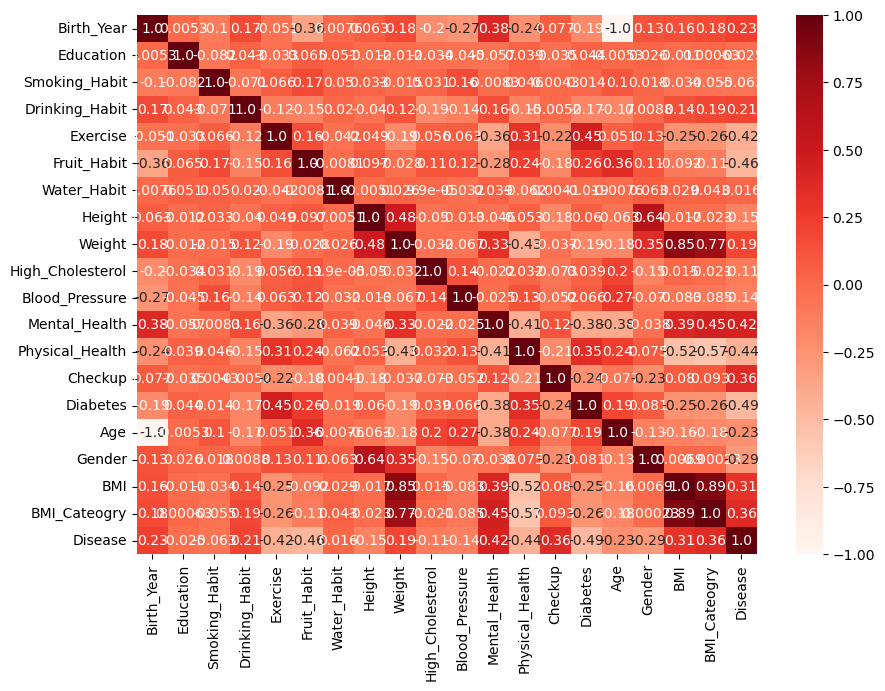

Index(['Diabetes', 'Physical_Health', 'Exercise', 'Fruit_Habit', 'Gender',
       'Age', 'Height', 'Blood_Pressure', 'Weight', 'Drinking_Habit',
       'Birth_Year', 'Checkup', 'BMI', 'BMI_Cateogry', 'Mental_Health'],
      dtype='object')

In [35]:
def cor_heatmap(cor):
    plt.figure(figsize=(10,7))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.2')
    plt.show()

cor_spearman = cor_heatmap(preprocessed_complete.corr("spearman"))

pearson_disease=preprocessed_complete.corr("pearson")["Disease"].sort_values()
pearson_coef=pearson_disease[(pearson_disease>0.1) | (pearson_disease<-0.1)]

pearson_coef=pearson_coef.drop(labels = "Disease").index
pearson_coef

In [31]:
def TestIndependence(X,Y,var,alpha=0.05):        
    dfObserved = pd.crosstab(Y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result= f"{var} is IMPORTANT for Prediction"
    else:
        result= f"{var} is NOT an important predictor. (Discard {var} from model)"
    print(result)

In [32]:
initial_xcategorical_col = [i for i in x.columns if i not in initial_xnumeric_cols]
initial_xcategorical_col.remove('Name')
initial_xcategorical_col.remove('Region')

for var in initial_xcategorical_col:
    TestIndependence(xtrain_prepro[var],ytrain, var)

Education is NOT an important predictor. (Discard Education from model)
Smoking_Habit is NOT an important predictor. (Discard Smoking_Habit from model)
Drinking_Habit is IMPORTANT for Prediction
Exercise is IMPORTANT for Prediction
Fruit_Habit is IMPORTANT for Prediction
Water_Habit is NOT an important predictor. (Discard Water_Habit from model)
Checkup is IMPORTANT for Prediction
Diabetes is IMPORTANT for Prediction


### Feature Selection - Wrapper Methods

In [33]:
model = RandomForestClassifier(random_state = 1)
rfe = RFECV(model, cv = 5, scoring = 'f1', n_jobs = -1)
rfe.fit(xtrain_prepro, ytrain)
opt_features = list(rfe.get_feature_names_out(input_features = list(xtrain_prepro.columns)))
print(f'Best features: {[i for i in opt_features]}')

Best features: ['Birth_Year', 'Education', 'Smoking_Habit', 'Drinking_Habit', 'Exercise', 'Fruit_Habit', 'Water_Habit', 'Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure', 'Mental_Health', 'Physical_Health', 'Checkup', 'Diabetes', 'Age', 'Gender', 'BMI', 'BMI_Cateogry']


In [34]:
xtrain_rfe = rfe.transform(xtrain_prepro)
xval_rfe = rfe.transform(xval_prepro)

### Feature Selection - Embedded Method

In [22]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [30]:
lasso = LassoCV()
lasso.fit(xtrain_prepro, ytrain)

coef = pd.Series(lasso.coef_, index = xtrain_prepro.columns)
coef.sort_values()

Gender                            -0.252358
Diabetes                          -0.176060
Exercise                          -0.155195
Physical_Health                   -0.083136
Fruit_Habit                       -0.082525
Region_north west                 -0.067276
Blood_Pressure                    -0.035780
High_Cholesterol                  -0.031670
Region_london                     -0.008240
Birth_Year                        -0.000000
Region_south west                 -0.000000
Region_south east                  0.000000
Region_north east                  0.000000
Region_east of england            -0.000000
BMI                                0.000000
Region_yorkshire and the humber    0.000000
Smoking_Habit                     -0.000000
Education                          0.000000
Age                                0.000000
Height                             0.004432
Region_east midlands               0.008196
Water_Habit                        0.010020
BMI_Cateogry                    

In [31]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 18 variables and eliminated the other 10 variables


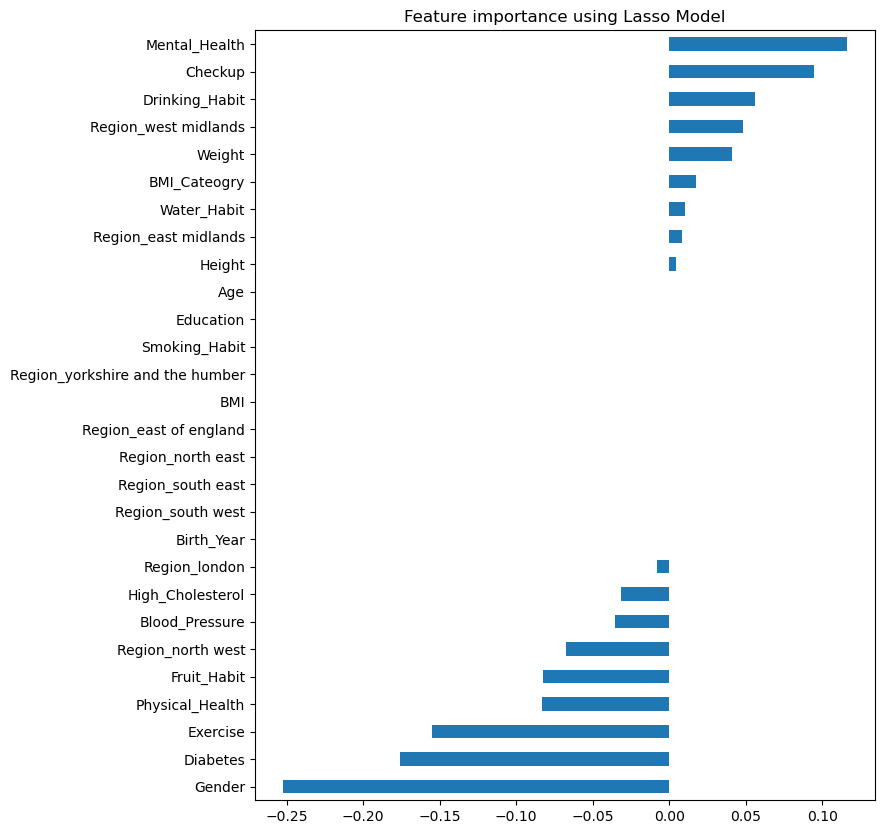

In [32]:
plot_importance(coef, "Lasso")

In [33]:
embedded_method_features = coef[coef != 0].index
embedded_method_features

Index(['Drinking_Habit', 'Exercise', 'Fruit_Habit', 'Water_Habit', 'Height',
       'Weight', 'High_Cholesterol', 'Blood_Pressure', 'Mental_Health',
       'Physical_Health', 'Checkup', 'Diabetes', 'Gender', 'BMI_Cateogry',
       'Region_east midlands', 'Region_london', 'Region_north west',
       'Region_west midlands'],
      dtype='object')

---
### Model Selection

In [40]:
#############################################################################################
# Replace ROC/AUC with Precision/Recall curve cross validated due to imbalance in the dataset
#############################################################################################

In [26]:
from sklearn.metrics import PrecisionRecallDisplay

def prec_rec(classifiers, xtrain, ytrain, xval, yval):

        fig, ax = plt.subplots(1, figsize=(15, 10))
        for name, clf in classifiers.items():
            clf.fit(xtrain, ytrain)
            PrecisionRecallDisplay.from_estimator(clf, xval, yval, ax=ax, name=name)
        ax.set_title('2-class Precision-Recall curve')
        ax.plot([0,1], [0,1], linestyle='--')
        plt.show()


        classifiers = {
                'Logistic Regression': LogisticRegression(),
                'Support Vector Machine': SVC(),
                'Neural Network': MLPClassifier(max_iter = 1000),
                'Decision Tree': DecisionTreeClassifier(),
                'Random Forest': RandomForestClassifier()
                }

In [27]:
prec_rec(classifiers, xtrain_rfe, ytrain, xval_rfe, yval)

NameError: name 'classifiers' is not defined

In [ ]:
def roc_auc(classifiers, xtrain, ytrain, xval, yval):
    '''
    Plots ROC/AUC
    classifiers input --> {'Logistic Regression': LogisticRegression(),...}
    '''

    fig, ax = plt.subplots(1, figsize=(15, 10))
    for name, clf in classifiers.items():
        clf.fit(xtrain, ytrain)
        RocCurveDisplay.from_estimator(clf, xval, yval, ax=ax, name=name)
    ax.set_title('Receiver Operating Characteristic (ROC)')
    ax.plot([0,1], [0,1], linestyle='--')
    plt.show()

classifiers = {
                'Logistic Regression': LogisticRegression(),
                'Support Vector Machine': SVC(),
                'Neural Network': MLPClassifier(max_iter = 1000),
                'Decision Tree': DecisionTreeClassifier(),
                'Random Forest': RandomForestClassifier()
                }

In [ ]:
roc_auc(classifiers, xtrain_rfe, ytrain, xval_rfe, yval)


---
### Neural Network - Optimizing

---
### Decision Tree - Optimizing

In [ ]:
model = DecisionTreeClassifier(random_state = 1)
model.fit(xtrain_rfe, ytrain)

ypred = model.predict(xval_rfe)

print(f'F1 Score: {f1_score(yval, ypred)}')

Check learning curve for overfitting

In [ ]:
def learning_curves(estimator, X, Y):
    '''
    Plots learning curve
    '''

    train_sizes, train_scores, validation_scores = learning_curve(estimator, X, Y, cv = 5, scoring = 'f1', train_sizes = np.arange(.05,1,.05))
    train_mean, test_mean, train_std, test_std = np.mean(train_scores, axis=1), np.mean(validation_scores, axis=1), np.std(train_scores, axis=1), np.std(validation_scores, axis=1)

    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, color='salmon',  label='Training score', marker = 'o')
    plt.plot(train_sizes, test_mean, color='olive', label='Cross-validation score', marker = 's')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score')
    plt.legend(loc='best')
    plt.show()

learning_curves(DecisionTreeClassifier(random_state=1), xtrain_rfe, ytrain)

Clearly overfitting - Hyperparameter tuning needed

In [ ]:
param_grid = {
                'criterion' :['gini', 'entropy'],
                'max_features': ['auto', 'sqrt', 'log2', None],
                'max_depth' : np.arange(2,10),
                'min_samples_leaf': np.arange(2,10),
                'ccp_alpha': [0.1, .01, .001]
             }


model = DecisionTreeClassifier(random_state = 1)
rand_search = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'f1', n_iter = 100, cv = 3, verbose=2, random_state=3, n_jobs = -1)
rand_search.fit(xtrain_rfe, ytrain)

print(str(rand_search.best_params_).replace('{','').replace('}','').replace("'","").replace(':','='))

In [ ]:
learning_curves(DecisionTreeClassifier(**rand_search.best_params_, random_state=1), xtrain_rfe, ytrain)

In [ ]:
model = DecisionTreeClassifier(**rand_search.best_params_, random_state = 1)
model.fit(xtrain_rfe, ytrain)

ypred = model.predict(xval_rfe)

print(f'F1 Score: {f1_score(yval, ypred)}')

Still overfitting - lets try another option --> Ensemble

### Random Forest - Optimizing

In [ ]:
model = RandomForestClassifier(random_state = 1)
model.fit(xtrain_rfe, ytrain)

ypred = model.predict(xval_rfe)

print(f'F1 Score: {f1_score(yval, ypred)}')

Check learning curve for overfitting

In [ ]:
def learning_curves(estimator, X, Y):
    '''
    Plots learning curve
    '''

    train_sizes, train_scores, validation_scores = learning_curve(estimator, X, Y, cv = 5, scoring = 'f1', train_sizes = np.arange(.05,1,.05))
    train_mean, test_mean, train_std, test_std = np.mean(train_scores, axis=1), np.mean(validation_scores, axis=1), np.std(train_scores, axis=1), np.std(validation_scores, axis=1)

    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, color='salmon',  label='Training score', marker = 'o')
    plt.plot(train_sizes, test_mean, color='olive', label='Cross-validation score', marker = 's')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score')
    plt.legend(loc='best')
    plt.show()

learning_curves(RandomForestClassifier(random_state = 1), xtrain_rfe, ytrain)

Slightly overfitting - Hyperparameter tuning could solve this problem

In [ ]:
param_grid = {
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False],
                'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10],
                'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
            }

model = RandomForestClassifier(random_state = 1)
rand_search = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'f1', n_iter = 100, cv = 3, verbose=2, random_state=3, n_jobs = -1)
rand_search.fit(xtrain_rfe, ytrain)

print(str(rand_search.best_params_).replace('{','').replace('}','').replace("'","").replace(':','='))

In [ ]:
learning_curves(RandomForestClassifier(**rand_search.best_params_, random_state=1), xtrain_rfe, ytrain)

In [ ]:
model = RandomForestClassifier(**rand_search.best_params_, random_state = 1)
model.fit(xtrain_rfe, ytrain)

ypred = model.predict(xval_rfe)

print(f'F1 score: {f1_score(yval, ypred)}')

---
### Stochastic Gradient Descent Classifier (SGD)

In [43]:
#Sources:https://scikit-learn.org/stable/modules/sgd.html#classification
#https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/

#First try with the SGD Classifier:
#implementation of the logistic regression
#penalty="l2": L2 norm penalty on coef_.

#embedded_method_features

sgd_clf = SGDClassifier(random_state = 234567890)


sgd_clf.fit(xtrain_prepro, ytrain)
sgd_ypred = sgd_clf.predict(xval_prepro)
print("All Variables", f'F1 score: {f1_score(yval, sgd_ypred)}')

#We get the coefficient values and connect it the the respective features

coef_dict = {}
for coef, feat in zip(sgd_clf.coef_[0,:], sgd_clf.feature_names_in_):
    coef_dict[feat] = coef
coef_ser = pd.Series(coef_dict).sort_values()

#Feature Selection:

#Wrapper Method
wrapper=coef_ser[(coef_ser > 0.5) | (coef_ser < -0.5)].index
sgd_clf.fit(xtrain_prepro[wrapper], ytrain)
sgd_ypred = sgd_clf.predict(xval_prepro[wrapper])
print("Wrapper Method (coef. > |0.5|)", f'F1 score: {f1_score(yval, sgd_ypred)}')

#Lasso Regression
sgd_clf.fit(xtrain_prepro[embedded_method_features], ytrain)
sgd_ypred = sgd_clf.predict(xval_prepro[embedded_method_features])
print("Embedded Method (Lasso)", f'F1 score: {f1_score(yval, sgd_ypred)}')


#Filter Method: Pearson Correlation
sgd_clf.fit(xtrain_prepro[pearson_coef], ytrain)
sgd_ypred = sgd_clf.predict(xval_prepro[pearson_coef])
print("Filter Method (cor. > |0.1|)", f'F1 score: {f1_score(yval, sgd_ypred)}')


All Variables F1 score: 0.8287292817679557
Wrapper Method (coef. > |0.5|) F1 score: 0.8494623655913979
Embedded Method (Lasso) F1 score: 0.8271604938271605
Filter Method (cor. > |0.1|) F1 score: 0.8433734939759037


In [54]:
#Instead of going through all the different hyperparameters one by one 
#We utilize the grid search method to find the best 
#hyperparameters for the stochastic gradient descent classifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

import time

start = time.time()
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
    "max_iter": [5, 10, 20, 50, 100, 1000], 
    "shuffle": [True, False], 
    "fit_intercept": [True, False],
    "learning_rate": ["constant", "optimal", "invscaling", "adaptive"]
    
}

sgd_clf3 = SGDClassifier(random_state = 21)
grid = GridSearchCV(sgd_clf3, param_grid=params, cv=10, scoring = "f1")

grid.fit(xtrain_prepro[wrapper], ytrain)
stop = time.time()
print(grid.best_params_) 
print(f"Grid Search Time: {stop - start}s")


{'alpha': 0.1, 'fit_intercept': True, 'loss': 'modified_huber', 'max_iter': 10, 'penalty': 'elasticnet', 'shuffle': False}
Grid Search Time: 177.72511839866638s


In [52]:
#{'alpha': 0.01, 'loss': 'modified_huber', 'max_iter': 20, 'n_jobs': 1, 'penalty': 'l2', 'shuffle': True}
grid_predictions = grid.predict(xval_prepro[wrapper]) 
print('F1: {:.2f}'.format(f1_score(yval, grid_predictions)))

F1: 0.86


---
### Submission 

**1** - Train on full dataset

In [ ]:
# apply encoding & scaling
# reset_fit set to True for new fit_transform (including all train observations)
xtrain_prepro_full = encode_scale(preprocessing(x), reset_fit = True)

In [ ]:
# apply feature selection on full train dataset
xtrain_rfe_full = rfe.transform(xtrain_prepro_full)

In [ ]:
# fit decision tree model
# optimized f1 score of validation split = 0.89
# submission f1 score = 0.95

# model = RandomForestClassifier(**rand_search.best_params_, random_state = 1)
# model.fit(xtrain_rfe_full, y)

In [ ]:
# fit model with best hyperparameters
model = RandomForestClassifier(**rand_search.best_params_, random_state = 1)
model.fit(xtrain_rfe_full, y)

**2** - Prepare test dataset and predict

In [ ]:
# apply preprocessing function and encode_scale function to test dataset
xtest_prepro = encode_scale(preprocessing(df_test))

In [ ]:
xtest_rfe = rfe.transform(xtest_prepro)

In [ ]:
ypred = model.predict(xtest_rfe)

In [ ]:
df_submission = pd.concat([pd.Series(df_test.index),pd.Series(ypred)], axis = 1)
df_submission.rename(columns = {0:'Disease'}, inplace = True)
df_submission

In [ ]:
# df_submission.to_csv('Group01_Final_RandomForest.csv', index = False)